# Importint libs

In [ ]:

import sys
import numpy as np
from google.colab.patches import cv2_imshow
import random
import timeit
import matplotlib.pyplot as plt


try:
  import cv2
  import torch
  import sklearn
  from sklearn.metrics import confusion_matrix as conf_m
except:
  # install missing packages
  !{sys.executable} -m pip install opencv-python
  !{sys.executable} -m pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
  !{sys.executable} -m pip install -U scikit-learn
  !{sys.executable} -m pip install -U scikit-learn
  
  import cv2
  import torch
  import sklearn
  from sklearn.metrics import confusion_matrix as conf_m

from torchvision import datasets, transforms

print ('importing done')
# timing the notebook
tic_start = timeit.default_timer()

importing done


# Load the mnist dataset for the image and put it in an image


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
[[array(9), (52, 38)]]


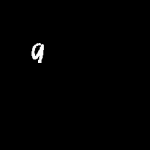

The image is shown above


In [ ]:


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(mnist_testset, shuffle=True)
train_loader = torch.utils.data.DataLoader(mnist_trainset, shuffle=True)

examples_test = enumerate(test_loader)
examples_train = enumerate(train_loader)

# image_create function 
# examples - dataset from which we load the images 
# num_of_digits_in_img - how many numbers in the big image 
# im_hight - hight of big image
# im_width - width of big image
#
# img - return value, the image that the function created with the numbers
# location - return value, center of the digit in the big image - (y,x) is in a top left coordinates
def image_create(examples, num_of_digits_in_img, im_hight = 200, im_width = 300): 
    
    # print(type(examples))
    
    img = np.zeros((im_hight,im_width,1),np.uint8)
    location = []

    for k in range(num_of_digits_in_img):
        _, (num_img, num_lable) = next(examples)

        num_lable = np.array(num_lable[0])
        num_img = np.array(num_img[0][0])
        # print('a random '+ str(num_lable) + ' image from mnist') 
        
        ## normalize the image to 0 - 255 range
        # print( 'max pixel is ' + str(np.max(num_img)) + ' and the min is ' + str(np.min(num_img)) )
        num_img = num_img - np.min(num_img)
        num_img = 255 * num_img / np.max(num_img)
        #cv2_imshow(num_img)


        x_offset = random.randint(0, im_width - 28)
        y_offset = random.randint(0, im_hight - 28)


        location.append([num_lable, ((y_offset + 28//2), (x_offset + 28//2))])  # [number, (mid_y, mid_x)]
        
        img[ y_offset : y_offset+28 , x_offset : x_offset+28 ] = np.reshape(num_img,(28,28,1))

    return img, location

# Testing of the image creation function
# examples_train - dataset from which we load the images 
# num_of_digits_in_img - how many numbers in the big image 
# im_hight - hight of big image
# im_width - width of big image
#
# img - return value, the image that the function created with the numbers
# location - return value, center of the digit in the big image - (y,x) is in a top left coordinates
img, location = image_create(examples_train, num_of_digits_in_img = 1 , im_hight = 150, im_width = 150)

print(location)
cv2_imshow(img)
print('The image is shown above')
    

# PyTorch based standared Network
I use a pytorch library example code 

in order to recognize a digit in  a 28 by 28 image

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # ch input, ch output, mask_size, 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)          # input: [Batch_size = 1, #ch = 1, h = 28, w = 28], output: [Batch_size = 1, #ch = 32, h = 26, w = 26]
        x = F.relu(x)              # relu activation function -  ___/
        x = self.conv2(x)          # input: [Batch_size = 1, #ch = 32, h = 26, w = 26], output: [Batch_size = 1, #ch = 64, h = 24, w = 24]
        x = F.relu(x)
        x = F.max_pool2d(x, 2)     # image size decreases by 4 -output = 64 ch of 12 by 12 (each pxl represents the maximal val of 4 neighbouring pxls)
        x = self.dropout1(x)       # dropout 0.25
        x = torch.flatten(x, 1)    # 64 * 12 * 12 = 9216 features in a 1*9216 vector
        x = self.fc1(x)            # 9216 features fully conected to 128 neurons
        x = F.relu(x)              # activation function - relu
        x = self.dropout2(x)       # dropout 0.5
        x = self.fc2(x)            # 128 features fully conected to 10 neurons
        output = F.log_softmax(x, dim=1)       # classes 0 - 9 
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()      
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



the training is performed here:

In [ ]:
def main_training():


    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    parser.add_argument('-f')  
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_model.pt")



if __name__ == '__main__':

    main_training()


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305401
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.359776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.842885
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.587047
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.368606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.468520
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.262679
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.282880
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.601316
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.216666
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.243167
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.327008
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.188426
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.196019
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.283869
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.107349
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.287562
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.093805
Train Epoch: 1 [11520/60000 (19

from the image we take a 28*28 sub images with a step of 15 pixels

each image will go through the trained model and we will estimate if there was an image there or not and what was the number inside.  

# Identify the location and number

In [ ]:
# find_num function 
# img - input image [there is a number in the image somewhere]
# candid_pred - return value - describes the digit predicted by the net
# candid_loc - return value - describes the estimated location found by the net
# candid_sub_img - return value - the 28*28 sub_image found by the net
# maximal_diff_lable - return value - certainty evaluation the maximal log_softmax - avarage(log_softmax[output]) - the higher the number the better prediction (20 - bad ; 2000 - good)  
def find_num(img):
    dimensions = img.shape
    # print(dimensions)
    # cv2_imshow(img)

    norm_img = img / 255    # here I scale the image to range 0.0-1.0 

    model = Net()
    checkpoint = torch.load('mnist_model.pt')
    model.load_state_dict(checkpoint)

    jump_size = 3 # pixles
    window_size = 28
    #print (jump_size)
    steps_x = 1 + (dimensions[1]-window_size)//jump_size 
    steps_y = 1 + (dimensions[0]-window_size)//jump_size
    #print("there are " + str(steps_x) + " steps along x dimention and " 
    #      + str(steps_y) + " steps along y dimention")

    maximal_diff_lable = 0
    for row in range(steps_y):
        for col in range(steps_x):
            
            # corners of the sum img
            up_left = [row*jump_size,col*jump_size]
            down_rt = [row*jump_size+window_size,col*jump_size+window_size]

            if down_rt[0] > dimensions[0]:
                crction = down_rt[0] - dimensions[0]
                down_rt[0] -= crction
                up_left[0] -= crction

            if down_rt[1] > dimensions[1]:
                crction = down_rt[1] - dimensions[1]
                down_rt[1] -= crction
                up_left[1] -= crction
            
            sub_img = img[ up_left[0]:down_rt[0] , up_left[1]:down_rt[1]]
            if np.sum(sub_img) == 0:
                continue
            sub_img_norm = torch.tensor(np.reshape(norm_img[ up_left[0]:down_rt[0] , up_left[1]:down_rt[1]], (1,1,28,28)).astype('float32'))
            
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            data = sub_img_norm.to(device)
            data = np.reshape(torch.tensor(sub_img.astype('float32')).to(device), (1,1,28,28))
            
            output = model(data)
            diff_lable = (torch.max(output) - torch.mean(output)).item()
            if diff_lable > maximal_diff_lable:
                maximal_diff_lable = diff_lable
                candid_sub_img = sub_img
                candid_loc = [up_left,down_rt]
                candid_pred = output.argmax().numpy()
                
            if np.max(sub_img) >= 200:
                # print(diff_lable)
                # print(output)
                # print([up_left,down_rt])
                # cv2_imshow(sub_img)
                pass
        

    #print(candid_pred)
    #print(candid_loc)
    #cv2_imshow(candid_sub_img)
    #print(maximal_diff_lable)
    return candid_pred, candid_loc, candid_sub_img, maximal_diff_lable
            

In [ ]:
img, location = image_create(examples_train, num_of_digits_in_img = 1 , im_hight = 230, im_width = 400)



In [ ]:
candid_pred, candid_loc, candid_sub_img, maximal_diff_lable = find_num(img)
print('the real number is : ' + str(location[0][0]))
print('the number found is: ' + str(candid_pred))

print('the location of the number is    : ' + str(location[0][1]))
print('the location found by the net is : ' + str(np.mean(candid_loc,axis = 0)))


the real number is : 0
the number found is: 0
the location of the number is    : (26, 229)
the location found by the net is : [ 26. 230.]


# Network Performance Analisis
I will test the flowing
*   accuracy (and a confusion matrix)
*   result offset



In [ ]:

# we need to make a use of all the test set now. 
# using the test prediction of all the numbers in the test set
def net_accuracy(test_size = 1000, check_rate = 100, image_creation
                   = lambda : image_create(examples_test, num_of_digits_in_img = 1 , im_hight = 100, im_width = 130)):
    pred_num = np.zeros(test_size)
    pred_loc = np.zeros((test_size,2))

    real_num = np.zeros(test_size)
    real_loc = np.zeros((test_size,2))

    # timing the test
    tic = timeit.default_timer()

    for k in range(test_size):
        if (k+1)//check_rate==(k+1)/check_rate:
            print('The number of checked examples is : ' + str(k+1) + '/' + str(test_size))
            toc = timeit.default_timer()
            print('elapsed time = ' + str(toc-tic))
        # create an example
        img, location = image_creation()
        if k <=3:
            print('Image '+str(k+1)+':')
            cv2_imshow(img)
        # run the example in the net
        candid_pred, candid_loc, candid_sub_img, maximal_diff_lable = find_num(img)

        # save the results in the arrays
        pred_num[k] = location[0][0]
        pred_loc[k] = location[0][1]

        real_num[k] = candid_pred
        real_loc[k] = np.mean(candid_loc,axis = 0)

    accuracy = np.sum(pred_num[:k] == real_num[:k]) / k
    print('the identification accuracy of the network is : ' + str(accuracy))


    confusion_mat = conf_m(real_num[1:k], pred_num[1:k])
    norm_conf = confusion_mat/confusion_mat.sum(axis=1)

    fig, ax = plt.subplots()
    min_val, max_val = 0, 1
    print('\nThe normalized confusion matrix: ') 
    ax.matshow(norm_conf, cmap=plt.cm.YlGn)
    plt.show()

    print('\nThe values of the confusion matrix are: \n'+ str(confusion_mat))

    print('\nA histogram of the sq.dist \nbetween the center of the number found \nand the real number center:')
    distance = np.sqrt(np.sum((pred_loc[:k]-real_loc[:k])**2,axis = 1))
    num_bins = 10
    plt.hist(distance, num_bins, density=False, facecolor='blue', alpha=0.5)
    plt.show()
    print('mean distance = ' + str(np.mean(distance)))

    print('\nA histogram of the sq.dist \nfor the correct classification:')
    distance_of_correct = distance[(pred_num[:k] == real_num[:k])]
    plt.hist(distance_of_correct, num_bins, density=False, facecolor='red', alpha=0.5)
    # dimention mismatch error : boolean index did not match indexed array along dimension 0; dimension is 300 but corresponding boolean dimension is 299
    # print('\nA histogram of the sq.dist of the correct classification \nbetween the center of the number found \nand the real number center:')
    # distance = np.sqrt(np.sum((pred_loc[(pred_num[:k] == real_num[:k])]-real_loc[(pred_num[:k] == real_num[:k])])**2,axis = 1))

net_accuracy is calculated by 


*   The accuracy (how meny correct predictions were devided by the number of examples) and the confusion matrix to identify the problematic numbers - the closer the accuracy is to 1 the better

*   and the square distance (in pixels) between the center of the image and the center of the recognized image - the closer it is to zero the better



Image 1:


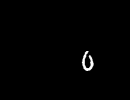

Image 2:


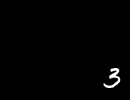

Image 3:


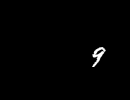

Image 4:


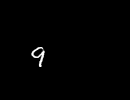

The number of checked examples is : 100/300
elapsed time = 33.810512665999795
The number of checked examples is : 200/300
elapsed time = 68.67123245499988
The number of checked examples is : 300/300
elapsed time = 104.30601109000008
the identification accuracy of the network is : 0.8729096989966555

The normalized confusion matrix: 


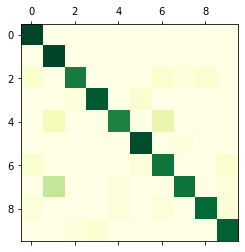


The values of the confusion matrix are: 
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 2  0 25  0  0  0  2  1  2  0]
 [ 0  0  1 35  0  2  0  0  0  0]
 [ 0  2  0  0 22  0  5  0  0  0]
 [ 0  0  0  0  0 28  0  1  0  0]
 [ 2  0  0  0  0  1 22  0  0  2]
 [ 0  5  0  0  1  0  0 32  0  1]
 [ 1  0  0  0  1  0  1  0 26  1]
 [ 0  0  1  2  0  0  0  0  0 25]]

A histogram of the sq.dist 
between the center of the number found 
and the real number center:


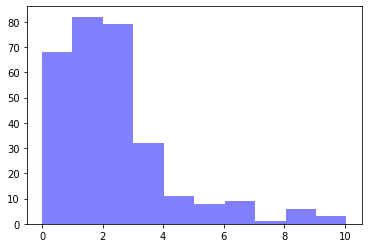

mean distance = 2.4203178428986445

A histogram of the sq.dist 
for the correct classification:


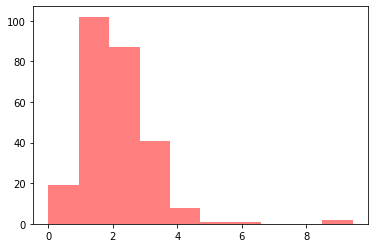

In [ ]:
net_accuracy(test_size = 300)


# Adding changes
*  gaussian noise
*  rotation up to 45 deg

Image 1:


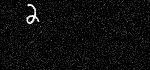

Image 2:


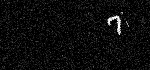

Image 3:


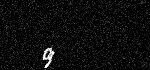

Image 4:


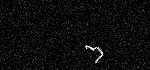

The number of checked examples is : 100/150
elapsed time = 123.81892527499986
the identification accuracy of the network is : 0.5167785234899329

The normalized confusion matrix: 


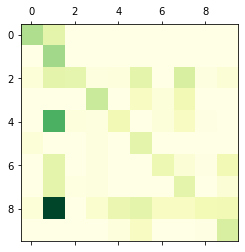


The values of the confusion matrix are: 
[[10  1  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 1  1 13  1  1  2  0  5  2  1]
 [ 0  0  0 14  0  1  1  3  0  0]
 [ 0  3  2  1  6  0  1  2  1  0]
 [ 1  0  0  1  0  2  0  0  0  0]
 [ 0  1  0  1  0  0  5  1  1  3]
 [ 0  1  1  1  0  0  0  4  0  1]
 [ 1  5  0  3  7  2  3  2 15  3]
 [ 0  0  0  0  1  1  0  0  1  5]]

A histogram of the sq.dist 
between the center of the number found 
and the real number center:


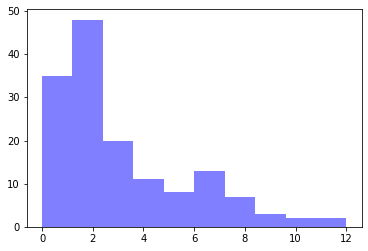

mean distance = 3.208753608667032

A histogram of the sq.dist 
for the correct classification:


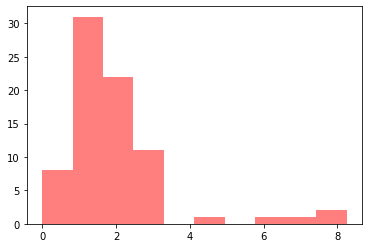

In [ ]:
def Add_gauss(img, n2r_ratio):
    # print(img.shape)
    row,col,chn= img.shape
    mean = 0
    sigma = n2r_ratio * 255 # approx. 10% signal to noise ratio - 50% accuracy. a 100 that is 50% S2N ratio yield garbage
    gauss = np.random.normal(mean,sigma,(row,col,chn))
    gauss = gauss.reshape(row,col,chn)
    noise_img = img + gauss
    return noise_img

def Add_rotation(deg):
    transform = transforms.Compose([
            transforms.RandomRotation(degrees=deg),
            transforms.ToTensor(),
            ])

    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(mnist_testset, shuffle=True)
    examples_test_rot = enumerate(test_loader)
    return examples_test_rot

def image_changed(deg, n2r_ratio):
    examples_rot = Add_rotation(deg)
    img, location = image_create(examples_rot, num_of_digits_in_img = 1, im_hight = 70, im_width = 150)
    img = Add_gauss(img, n2r_ratio)
    return img, location

def noisy_net_perform():
    deg = 45
    n2r_ratio = 0.1
    net_accuracy(test_size = 150, image_creation = lambda : image_changed(deg, n2r_ratio))
  

noisy_net_perform()


In [ ]:
toc_end = timeit.default_timer()
print('the total notebook elapsed time = ' + str(toc_end-tic_start))

the total notebook elapsed time = 2926.7243855770002
